# Working with Multi-Human Synthesis AI Datasets

First, we install `synthesisai` and download test datasets.

In [ ]:
%%bash
python -m pip install synthesisai
curl https://synthesisai-example-datasets.s3.amazonaws.com/scenarios_api_example_dataset.zip -o scenarios_api_example_dataset.zip
unzip scenarios_api_example_dataset.zip -d scenarios_api_example_dataset

Now we add some imports for the visualisation.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

We use `SaiDataset` class to access synthesis datasets.

In [3]:
from synthesisai import SaiDataset, Modality

In [4]:
data_root = "scenarios_api_example_dataset"
dataset = SaiDataset(data_root)

Ignoring unsupported modality Modality.UV
Ignoring unsupported modality Modality.LANDMARKS_CONTOUR_IBUG68
Ignoring unsupported modality Modality.FACIAL_HAIR
Ignoring unsupported modality Modality.LANDMARKS_3D_MEDIAPIPE_FACE
Ignoring unsupported modality Modality.LANDMARKS_3D_SAI
Ignoring unsupported modality Modality.LANDMARKS_MEDIAPIPE_FACE
Ignoring unsupported modality Modality.LANDMARKS_SAI


In [5]:
len(dataset)

1

In [6]:
item = dataset[0]

Each item is a dict with different modalities as keys.

In [7]:
item.keys()

dict_keys([<Modality.SCENE_ID: 1>, <Modality.RGB: 2>, <Modality.NORMALS: 3>, <Modality.DEPTH: 4>, <Modality.BODY_SEGMENTATION: 5>, <Modality.CLOTHING_SEGMENTATION: 6>, <Modality.INSTANCE_SEGMENTATION: 7>, <Modality.LANDMARKS_IBUG68: 9>, <Modality.LANDMARKS_KINECT_V2: 11>, <Modality.LANDMARKS_MEDIAPIPE: 12>, <Modality.LANDMARKS_COCO: 13>, <Modality.LANDMARKS_MPEG4: 14>, <Modality.LANDMARKS_3D_IBUG68: 15>, <Modality.LANDMARKS_3D_KINECT_V2: 16>, <Modality.LANDMARKS_3D_MEDIAPIPE: 17>, <Modality.LANDMARKS_3D_COCO: 18>, <Modality.LANDMARKS_3D_MPEG4: 19>, <Modality.PUPILS: 20>, <Modality.PUPILS_3D: 21>, <Modality.IDENTITY: 22>, <Modality.IDENTITY_METADATA: 23>, <Modality.HAIR: 24>, <Modality.EXPRESSION: 26>, <Modality.GAZE: 27>, <Modality.FACE_BBOX: 28>, <Modality.HEAD_TO_CAM: 29>, <Modality.CAM_TO_HEAD: 30>, <Modality.HEAD_TO_WORLD: 31>, <Modality.WORLD_TO_HEAD: 32>, <Modality.CAM_TO_WORLD: 33>, <Modality.WORLD_TO_CAM: 34>, <Modality.CAM_INTRINSICS: 35>, <Modality.CAMERA_NAME: 36>, <Modality

`RGB` modality is the rendered image.

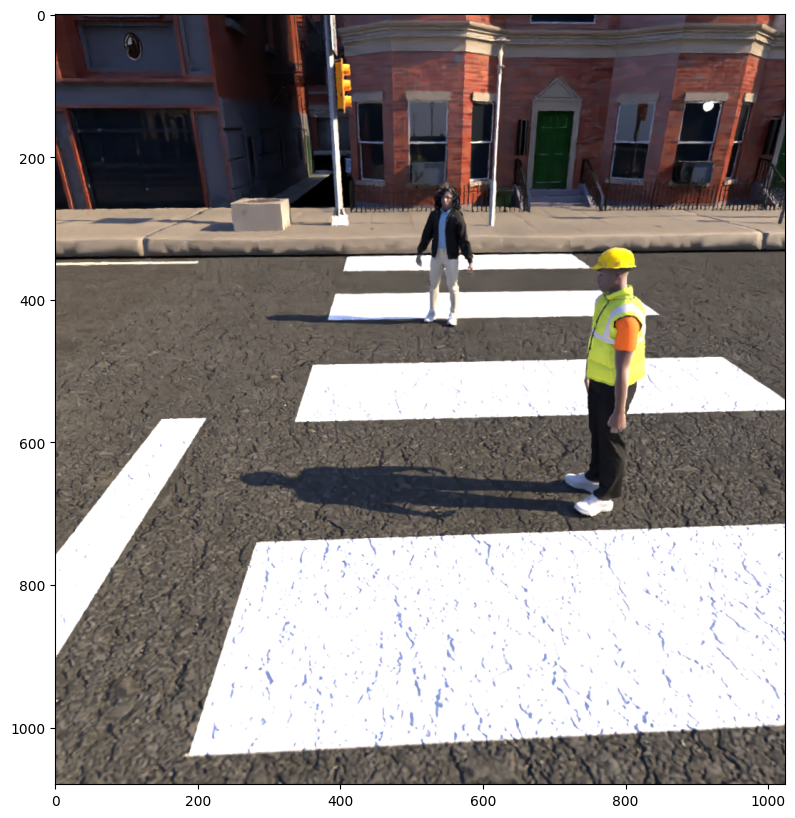

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(item[Modality.RGB])

You can access modalities in the same way as shown in the other notebooks. For example, you can get the landmarks as follows:

In [9]:
def landmark_show(img, landmarks, radius=2, labels=True):
    l_img = np.copy(img)
    for name, (x, y) in landmarks.items():
        int_p = (int(x), int(y))
        cv2.circle(l_img, int_p, radius=radius, color=(255, 0, 0), thickness=cv2.FILLED)
    plt.imshow(l_img)

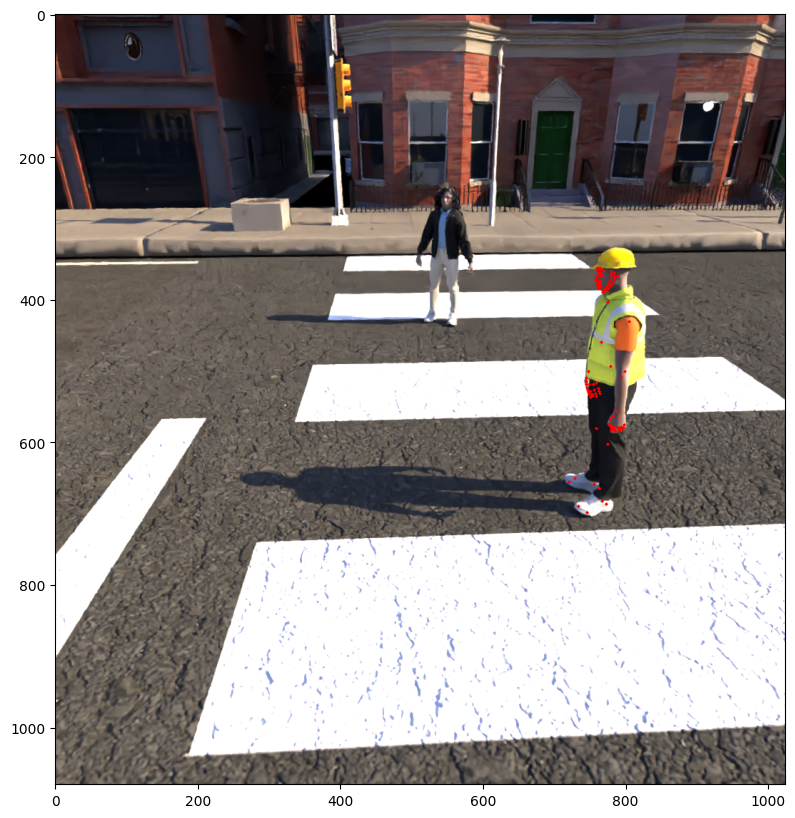

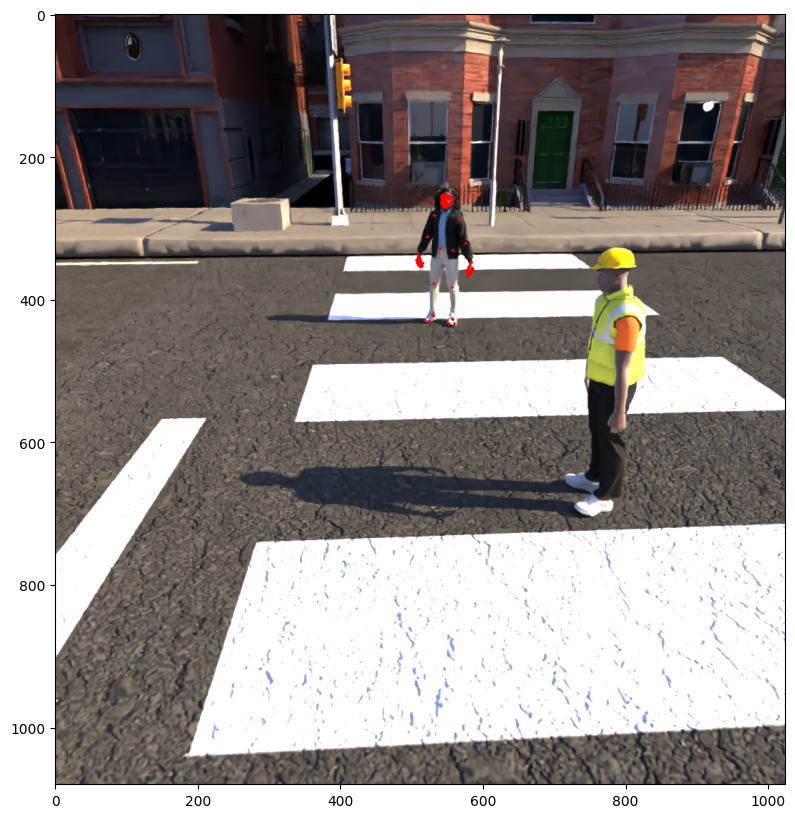

In [10]:
# grab the instance segmentation (more info on this below)
instance_seg, instance_mapping = item[Modality.INSTANCE_SEGMENTATION]
# this loop will only iterate once since there is only one human in this example
for human_instance_id, landmarks in item[Modality.LANDMARKS_COCO].items():
    # check to see if this human is visible in the image by looking at the instance segmentation map (more on this below)
    # and seeing if any of the pixels belong to this human
    if np.sum(instance_seg == instance_mapping[human_instance_id]) == 0:
        # skip if this human is not visible
        continue
    plt.figure(figsize=(10,10))
    landmark_show(item[Modality.RGB], landmarks)

The segmentation modalities provide a single semantic segmentation map for the entire image, which includes all the humans.

In [11]:
def discrete_show(data):
    cmap = plt.get_cmap('RdBu', np.max(data) - np.min(data) + 1)
    plt.imshow(data, cmap=cmap, vmin=np.min(data) - .5,
               vmax = np.max(data) + .5, interpolation="nearest")

(1080, 1024)


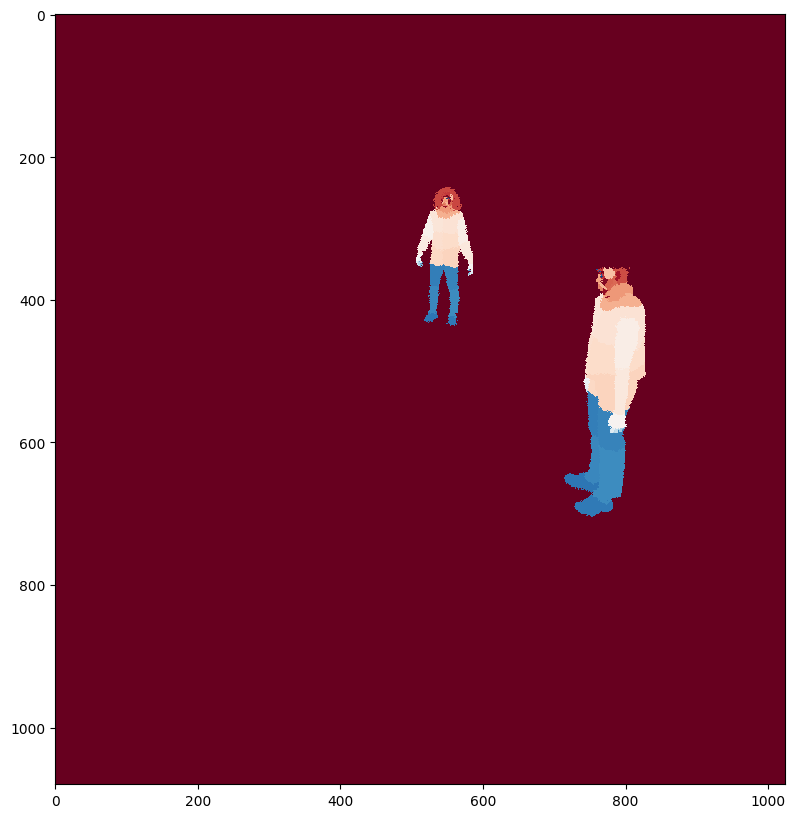

In [12]:
plt.figure(figsize=(10,10))
discrete_show(item[Modality.BODY_SEGMENTATION])
print(item[Modality.BODY_SEGMENTATION].shape)

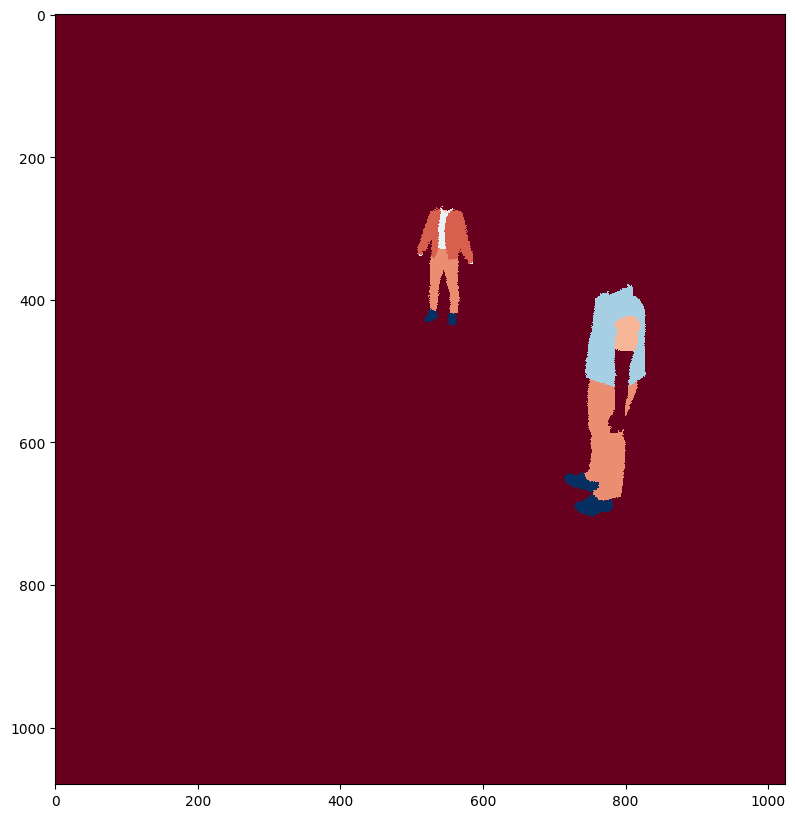

In [13]:
plt.figure(figsize=(10,10))
discrete_show(item[Modality.CLOTHING_SEGMENTATION])

There is also an `INSTANCE_SEGMENTATION` modality to let you figure out which pixels belong to which human.

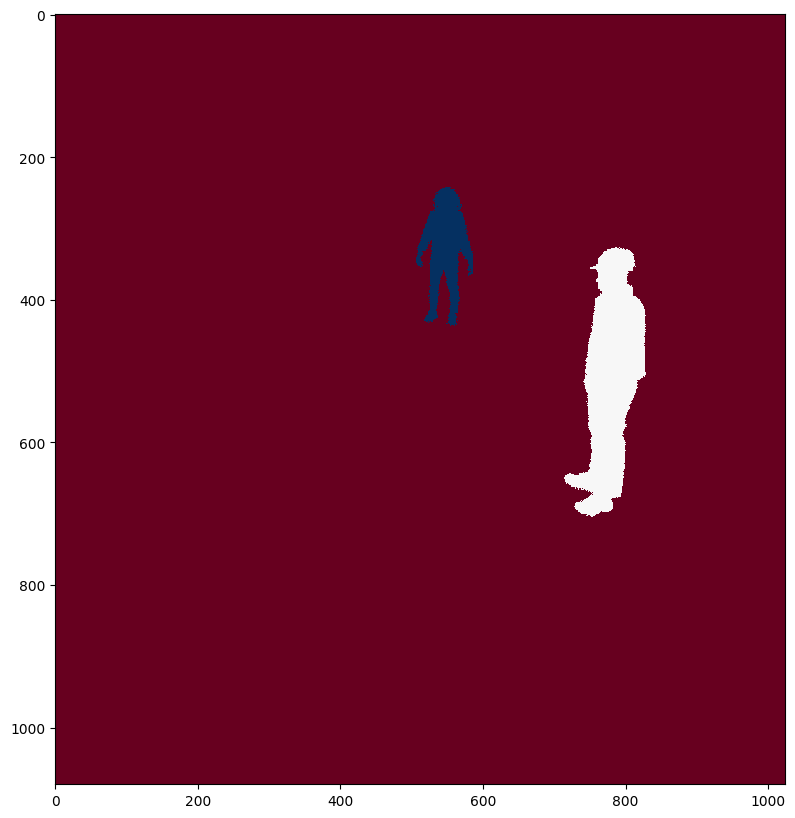

In [14]:
plt.figure(figsize=(10,10))
# instance_segmentation is a numpy int16 array containing integers
# instance_segmentation_mapping is a dictionary that maps human instance ids (eg. "human_8") to the integers in instance_segmentation
# Humans that are not visible in the image will map to -1
instance_segmentation, instance_segmentation_mapping = item[Modality.INSTANCE_SEGMENTATION]
discrete_show(instance_segmentation)

In [15]:
# Notice how the only values in the instance_segmentation are 0, 1 and 2
# Also notice how "background" maps to 0, "human_8" maps to 1, and "human_9" maps to 2, while all others map to -1.
# This is because only human_8 and human_9 are visible in this image.
print(np.unique(instance_segmentation))
print(instance_segmentation_mapping)

[0 1 2]
{'human_8': 1, 'human_9': 2, 'background': 0, 'human_1': -1, 'human_2': -1, 'human_3': -1, 'human_4': -1, 'human_5': -1, 'human_6': -1, 'human_7': -1}


We can combine the instance segmentation map with another segmentation map (eg. body segmentation) to produce a segmentation map for a specific human.

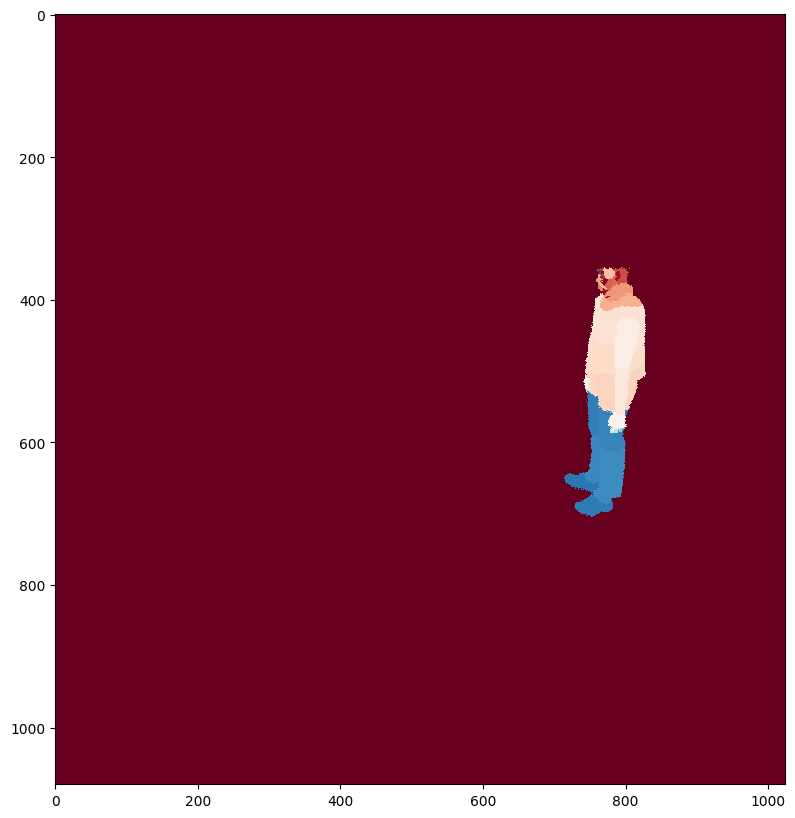

In [16]:
# let's get the body segmentation for the human with instance id = "human_8"
# because in this particular scene, there are 9 humans, but only the humans
# with instance IDs "human_8" and "human_9" are visible in the image
human_instance_id = "human_8"

body_segmentation = item[Modality.BODY_SEGMENTATION]
instance_segmentation, instance_segmentation_mapping = item[Modality.INSTANCE_SEGMENTATION]
instance_8_body_segmentation = body_segmentation.copy()
# set all pixels that don't correspond to human_8 to the background class
instance_8_body_segmentation[instance_segmentation != instance_segmentation_mapping[human_instance_id]] = SaiDataset.BODY_SEGMENTATION_MAPPING["background"]
plt.figure(figsize=(10,10))
discrete_show(instance_8_body_segmentation)

We can also get the face bounding boxes for all the humans in a given image

In [17]:
def plot_bboxes(image, face_bboxes):
    plt.figure(figsize=(10,10))

    for face_bbox in face_bboxes:
        image = cv2.rectangle(image.copy(), face_bbox[:2], face_bbox[2:], (255, 0, 0), 2)
    plt.imshow(image)

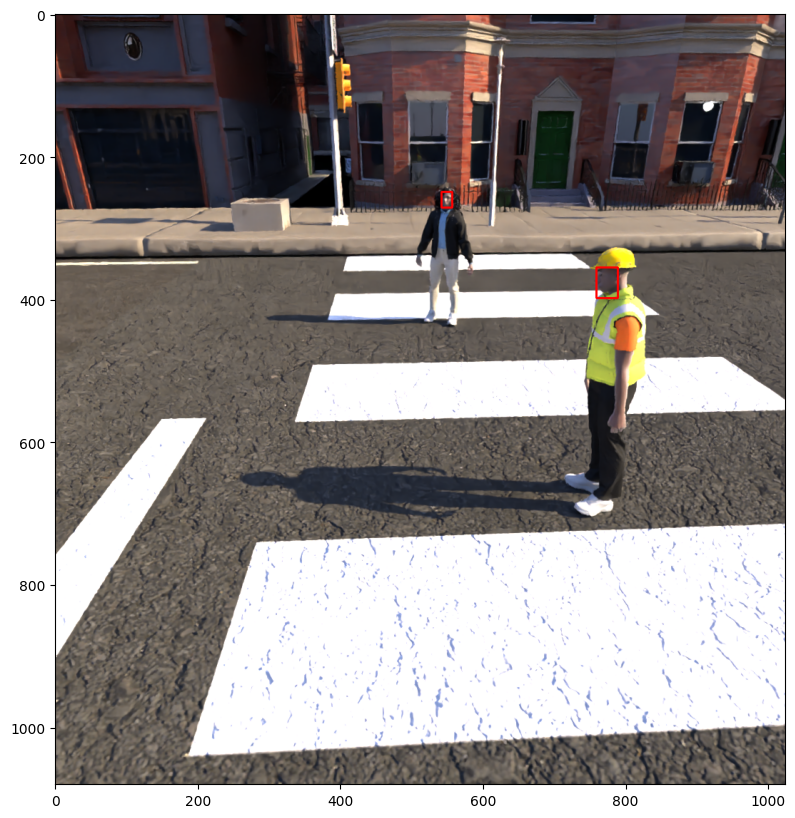

In [18]:
face_bboxes = []
for human_instance_id, face_bbox in item[Modality.FACE_BBOX].items():
    face_bboxes.append(face_bbox)
plot_bboxes(item[Modality.RGB], face_bboxes)